 <font size="6">Сегментация и детектирование</font>

# Задачи компьютерного зрения

В ходе предыдущих занятий, мы подробно рассмотрели задачу классификации изображений.


Но порой недостаточно знать, что на изображении есть объект определенного класса. Важно где именно расположен объект. В ряде случаев нужно знать еще и точные границы объекта. Например если речь идет о рентгеновском снимке или изображении клеток ткани полученном с микроскопа.


<img src ="https://edunet.kea.su/repo/EduNet-content/L12/img_license/classification_semantic_segmentation.png" width="600">


Определение того какие фрагменты изображения принадлежат объектам определенных класов это задача **сегментации** (segmentation).


Если нас интересуют не индивидуальные объекты, а только тип(класс) объекта которым занят конкретный пиксел (как в случае с клетками под микроскопом) то говорят о **семантической сегментации** (semantic segmentation)

<img src ="https://edunet.kea.su/repo/EduNet-content/L12/img_license/detection_instance_segmentation.png" width="600">

Если нас интересуют конкретные объекты, и при этом достаточно знать только область в которой объект локализован, то это задача **детектирования** (Detection)

В качестве примера такой задачи можно рассмотреть подсчет количество китов на спутниковом снимке.


Если же важны и индивидуальные объекты и их точные границы, то это уже задача **Instance segmentation**

## Dataset COCO — Common Objects in Context

Прежде чем говорить о способах решения этих задач, надо разбраться с форматами входных данных. Сделаем это на примере COCO.

Один из наиболее популярных датасатов содержащий данные для сегментации и детектирования. Он содержит более трёхсот тысяч изображений, большая часть из которых размечена и содержит следующую информацию:
- Категории
- Маски
- Ограничивающие боксы (*bounding boxes*)
- Описания (*captions*)
- Ключевые точки (*keypoints*)
- И многое другое

Формат разметки изображений, использованный в этом датасете, нередко используется и в других наборах данных. Как правило, он упоминается просто как "COCO format".

Загрузим датасет.

In [1]:
import requests, zipfile, io

r = requests.get(
    "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

Для работы с датасетом используется пакет `pycocotools`.

[Подробнее о том как создать свой COCO датасет с нуля](https://www.immersivelimit.com/tutorials/create-coco-annotations-from-scratch).

In [2]:
from pycocotools.coco import COCO

coco = COCO("annotations/instances_val2017.json")

loading annotations into memory...
Done (t=0.73s)
creating index...
index created!


Рассмотрим формат аннотаций на примере одной записи.

In [3]:
catIds = coco.getCatIds(catNms=["cat"])  # cats IDs
print('class ID(cat) = %i' % catIds[0])

imgIds = coco.getImgIds(catIds=catIds)  # Filtering dataset by tag
print("All images: %i" % len(imgIds))

class ID(cat) = 17
All images: 184


Рассмотрим метаданные.

In [4]:
img_list = coco.loadImgs(imgIds[0])  # 1 example
img = img_list[0]
img

{'coco_url': 'http://images.cocodataset.org/val2017/000000416256.jpg',
 'date_captured': '2013-11-18 04:05:18',
 'file_name': '000000416256.jpg',
 'flickr_url': 'http://farm1.staticflickr.com/34/64280333_7acf38cfb3_z.jpg',
 'height': 375,
 'id': 416256,
 'license': 5,
 'width': 500}

Посмотрим на изображение.

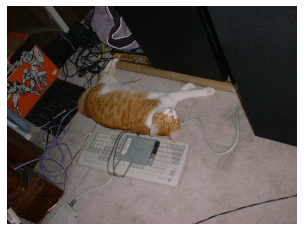

In [5]:
import skimage.io as io
import matplotlib.pyplot as plt

I = io.imread(img["coco_url"])
plt.axis("off")
plt.imshow(I)
plt.show()

Сконвертируем в PIL формат для удобства дальнейшей работы.

http://images.cocodataset.org/val2017/000000416256.jpg


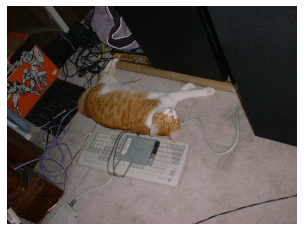

In [6]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

def coco2pil(url):
    print(url)
    response = requests.get(url)
    return Image.open(BytesIO(response.content))

pil_img = coco2pil(img["coco_url"])
plt.axis("off")
plt.imshow(pil_img)
plt.show()

### Категории в COCO

Давайте посмотрим на примеры категорий в нашем датасете. Отобразим каждую 10ую категорию.

In [7]:
cats = coco.loadCats(coco.getCatIds())  # loading categories
num2cat = {}  
print("COCO categories: ")
for cat in cats:
    num2cat[cat["id"]] = cat["name"]
    if cat["id"] in range(0, 80, 10):
        print(cat["id"], ":", cat["name"], end="   \n")

COCO categories: 
10 : traffic light   
20 : sheep   
40 : baseball glove   
50 : spoon   
60 : donut   
70 : toilet   


В датасете также есть категория **0**. Ее используют для обозначения класса фона.

Также существуют надкатегории. 

In [8]:
print(f'cats[2]: {cats[2]}')
print(f'cats[3]: {cats[3]}')

nms = set([cat["supercategory"] for cat in cats])
print("COCO supercategories: \n{}".format("\n".join(nms)))

cats[2]: {'supercategory': 'vehicle', 'id': 3, 'name': 'car'}
cats[3]: {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'}
COCO supercategories: 
accessory
appliance
food
furniture
kitchen
electronic
outdoor
vehicle
animal
sports
indoor
person


### Разметка данных

Помимо метаданных нам доступна разметка ([подробнее о разметке](https://cocodataset.org/#format-data)), давайте её загрузим и отобразим.

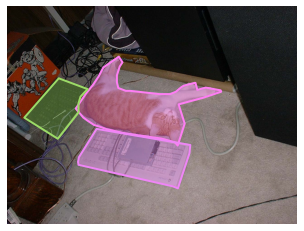

In [9]:
annIds = coco.getAnnIds(imgIds=img["id"])
anns = coco.loadAnns(annIds)

plt.imshow(I)
plt.axis("off")
coco.showAnns(anns)
plt.show()

На изображении можно увидеть разметку пикселей изображения по классам. То есть, пиксели из объектов, относящихся к интересующим классам, приписываются к классу этого объекта. К примеру, можно увидеть объекты двух классов: "cat" и "keyboard". 

Давайте теперь посмотрим, из чего состоит разметка.

In [10]:
def dump_anns(anns):
    for i, a in enumerate(anns):
        print(f"\n#{i}")
        for k in a.keys():
            if k == "category_id" and num2cat.get(a[k], None):
                print(k, ": ", a[k], num2cat[a[k]])  # Show cat. name
            else:
                print(k, ": ", a[k])

dump_anns(anns)


#0
segmentation :  [[157.26, 120.16, 165.32, 104.84, 191.94, 86.29, 198.39, 95.97, 193.55, 103.23, 188.71, 118.55, 188.71, 130.65, 191.13, 140.32, 204.03, 145.16, 211.29, 145.16, 262.1, 150.81, 280.65, 150.81, 290.32, 146.77, 300.0, 138.71, 304.03, 136.29, 322.58, 131.45, 324.19, 131.45, 327.42, 143.55, 341.94, 139.52, 367.74, 144.35, 368.55, 146.77, 337.1, 157.26, 312.9, 163.71, 295.16, 168.55, 299.19, 181.45, 305.65, 201.61, 293.55, 239.52, 288.71, 233.87, 265.32, 227.42, 225.0, 221.77, 199.19, 217.74, 170.97, 211.29, 159.68, 207.26, 149.19, 204.03, 137.1, 195.97, 130.65, 191.13, 117.74, 175.81, 134.68, 150.81, 147.58, 134.68]]
area :  15465.184599999999
iscrowd :  0
image_id :  416256
bbox :  [117.74, 86.29, 250.81, 153.23]
category_id :  17 cat
id :  51846

#1
segmentation :  [[122.48, 272.75, 284.67, 309.77, 293.93, 313.33, 313.86, 252.82, 315.29, 238.58, 153.67, 210.81, 123.06, 259.93, 121.64, 267.77]]
area :  12449.917949999995
iscrowd :  0
image_id :  416256
bbox :  [121.64, 2

Заметим, что аннотация изображения может состоять из описаний нескольких объектов, каждое из которых содержит следующую информацию:
* `segmentation` - последовательность пар чисел ($x$, $y$), координат каждой из вершин "оболочки" объекта;
* `area` - площадь объекта;
* `iscrowd` - информация о том, находится в оболочке один объект или же несколько, но слишком много для пообъектной разметки (толпа людей, к примеру);
* `image_id` - идентификатор изображения, к которому принаделжит описываемый объект;
* `bbox` - *будет рассмотрен далее в ходе лекции*;
* `category_id` - идентификатор категории, к которой относится данный объект;
* `id` - идентификатор самого объекта.

Попробуем посмотреть на пример, в котором `iscrowd = True` .


#0
segmentation :  {'counts': [272, 2, 4, 4, 4, 4, 2, 9, 1, 2, 16, 43, 143, 24, 5, 8, 16, 44, 141, 25, 8, 5, 17, 44, 140, 26, 10, 2, 17, 45, 129, 4, 5, 27, 24, 5, 1, 45, 127, 38, 23, 52, 125, 40, 22, 53, 123, 43, 20, 54, 122, 46, 18, 54, 121, 54, 12, 53, 119, 57, 11, 53, 117, 59, 13, 51, 117, 59, 13, 51, 117, 60, 11, 52, 117, 60, 10, 52, 118, 60, 9, 53, 118, 61, 8, 52, 119, 62, 7, 52, 119, 64, 1, 2, 2, 51, 120, 120, 120, 101, 139, 98, 142, 96, 144, 93, 147, 90, 150, 87, 153, 85, 155, 82, 158, 76, 164, 66, 174, 61, 179, 57, 183, 54, 186, 52, 188, 49, 191, 47, 193, 21, 8, 16, 195, 20, 13, 8, 199, 18, 222, 17, 223, 16, 224, 16, 224, 15, 225, 15, 225, 15, 225, 15, 225, 15, 225, 15, 225, 15, 225, 15, 225, 15, 225, 14, 226, 14, 226, 14, 39, 1, 186, 14, 39, 3, 184, 14, 39, 4, 183, 13, 40, 6, 181, 14, 39, 7, 180, 14, 39, 9, 178, 14, 39, 10, 177, 14, 39, 11, 176, 14, 38, 14, 174, 14, 36, 19, 171, 15, 33, 32, 160, 16, 30, 35, 159, 18, 26, 38, 158, 19, 23, 41, 157, 20, 19, 45, 156, 21, 15, 48, 1

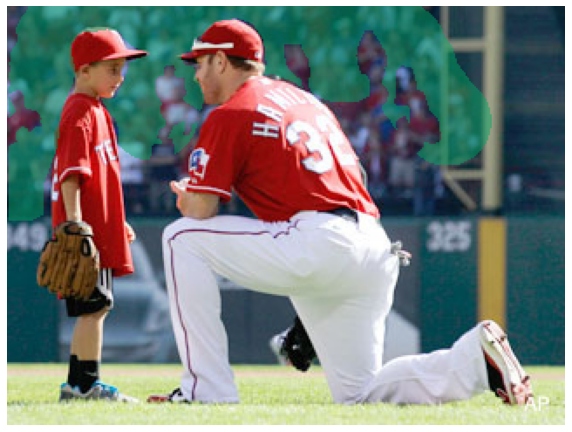

In [11]:
plt.rcParams["figure.figsize"] = (120, 60)

catIds = coco.getCatIds(catNms=["people"])
annIds = coco.getAnnIds(catIds=catIds, iscrowd=True)
anns = coco.loadAnns(annIds[0:1])

dump_anns(anns)
img = coco.loadImgs(anns[0]["image_id"])[0]
I = io.imread(img["coco_url"])
plt.figure(figsize=(10, 10))
plt.imshow(I)
coco.showAnns(anns)  # People in the stands
seg = anns[0]["segmentation"]
print("Counts", len(seg["counts"]))
print("Size", seg["size"])
plt.axis("off")
plt.show()

Используя методы из `pycocotools`, можно с лёгкостью преобразовать набор вершин "оболочки" сегментируемого объекта в более удобный для отображения вид - в маску объекта.

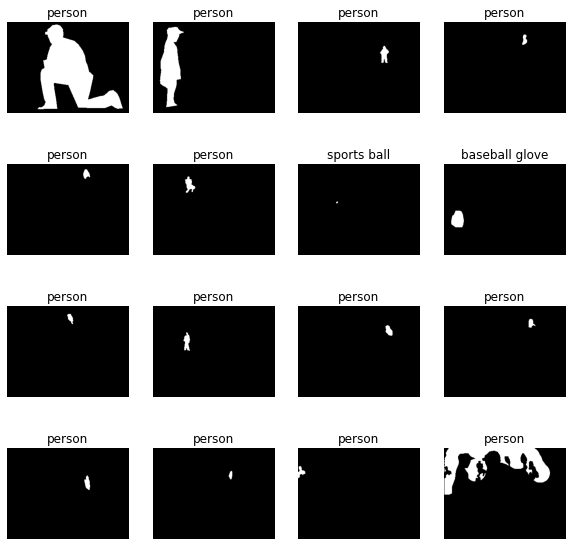

In [12]:
import numpy as np

annIds = coco.getAnnIds(imgIds=[448263])
anns = coco.loadAnns(annIds)
msk = np.zeros(seg["size"])

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))

i = 0
for row in range(4):
    for col in range(4):
        msk = coco.annToMask(anns[i])
        ax[row, col].imshow(msk, cmap = 'gray')
        ax[row, col].set_title(num2cat[anns[i]["category_id"]])
        ax[row, col].axis("off")
        i += 1
        
plt.show()

В некоторых случаях, попиксельная разметка изображения может быть избыточной - к примеру, в случае если необхдимо посчитать количество человек на изображении, достаточно просто каким-то образом промаркировать каждого из них, после чего посчитать количество наших "отметок". Одним из вариантов маркировки является "обведение" объекта рамкой (`bounding boxes`), внутри которой он находится. Такая информация об объектах также сохранена в аннотациях формата COCO.

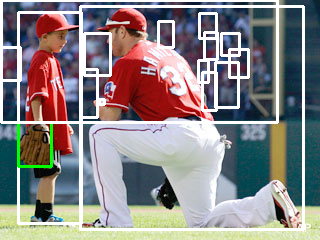

In [13]:
import cv2
from google.colab.patches import cv2_imshow

annIds = coco.getAnnIds(imgIds=[448263])
anns = coco.loadAnns(annIds)

RGB_img = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)

for i in range(len(anns)):
    x, y, width, heigth = anns[i]["bbox"]
    x, y, width, heigth = int(x), int(y), int(width), int(heigth)
    if anns[i]["category_id"] == 1: # person
        color = (255, 255, 255)
    if anns[i]["category_id"] == 40: # glove
        color = (0, 255, 0)
    RGB_img = cv2.rectangle(RGB_img, (x, y), (x + width, y + heigth), color, 2)
cv2_imshow(RGB_img)

#### $\color{brown}{\text{Дополнительная информация}}$ 
### Еще более глубокое понимание разметки

Что такое [run-length encoding - RLE](https://en.wikipedia.org/wiki/Run-length_encoding)

[Видео-разбор](https://www.youtube.com/watch?v=h6s61a_pqfM)

# Детектирование (Object detection)


<img src ="https://edunet.kea.su/repo/EduNet-content/L12/img_license/detection
.png" width="400">

Детектирование - задача компьютерного зрения, в которой требуется
определить местоположение конкретных объектов на изображении.

При этом вычислять точные границы объектов не требуется, а достаточно определить только ограничивающе прямоугольники (bounding boxes) в которых находятся объекты.

В общем случае объекты могут принадлежать к различным классам и объектов одного класса на изображении может быть несколько. 

## Детектирование единственного объекта

Но начнём с простой ситуации.

Пусть нас интересуют объекты только одного класса и мы знаем что такой объект на изображении есть и он один. 

К примеру мы разрабатываем систему по распознаванию документов:


<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/predict_bounded_box_example.png" width="700">

На вход модели подаётся изображение, и предсказать требуется область в которой объект локализован.
Область (bounding box) определяется набором координат вершин*. Собственно эти координаты и должна предсказать модель.





\* *Если наложить условие что стороны многоугольника должны быть параллельны сторонам изображения, то можно ограничится предсказанием 2-х координат.*







### Предсказание координат

Если задачу семантической сегментации получилось свести к классификации, то здесь будем использовать регрессию, поскольку предсказыать нужно не номер класса, а набор чисел.

В зависимости от требований эти числа могут нести разный смысл, например:

* координаты центра + ширина и высоту
* координаты правого верхнего и левого нижнего углов
* координаты вершин многоугольника ...

Но в любом случае задача остается регрессионной.


Решается она так так:

Берем сверточную сеть, и меняем последний полносвязанный слой таким образом, что бы количество  выходов совпадало с количеством координат которые нам нужно предсказать.

Так для предсказания двух точек потребуется четыре выхода ( x1 , y1 , x2, y2 )




In [17]:
from IPython.display import clear_output
from torchvision.models import resnet18
from torch import nn

# load pretrained model
resnet_detector = resnet18(pretrained=True)
clear_output()
# Change "head" to predict coordinates (x1,y1 x2,y2)
resnet_detector.fc = nn.Linear(resnet_detector.fc.in_features, 4)  # x1,y1 x2,y2

Для обучения такой модели придется заменить функцию потерь на регрессионную, например MSE.

In [16]:
import torch
criterion = nn.MSELoss()

# This is a random example. Don't expect good results
input = torch.rand((1, 3, 224, 224))
target = torch.tensor([[0.1, 0.1, 0.5, 0.5]])  # x1,y1 x2,y2 or x,y w,h
print(f'Target: {target}')
output = resnet_detector(input)
loss = criterion(output, target)
print(f'Output: {output}')
print(f'Loss: {loss}')

Target: tensor([[0.1000, 0.1000, 0.5000, 0.5000]])
Output: tensor([[-0.1818, -1.1650, -0.2265,  0.3831]], grad_fn=<AddmmBackward0>)
Loss: 0.5552866458892822


Координаты обычно предсказываются в процентах от длины и ширины изображения.
Таким образом, если bounding box целиком помещается на изображении  обе координаты будут находится в интервале от $[0 .. 1]$




<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/predict_key_points.png" width="700"></center>
<center><em>Примеры предсказывания точек (Humphreys et al., 2020)</em></center>

[Recent Progress in Appearance-based Action Recognition (Humphreys et al., 2020)](https://arxiv.org/abs/2011.12619)


По такому принципу работают многое модели для поиска различных ключевых точек.
Например на лице(facial landmarks) или теле целовека.

### Multitask loss

Координаты прямоугольников мы предсказывать научились.

Теперь усложним задачу: объект остается один, но может принадлежать к различным классам. 

<img src ="https://edunet.kea.su/repo/EduNet-content/L12/img_license/one_object.png" width="900">

То есть к задаче локализации добавляется классификация.

Задачу классификации мы умеем решать:

<img src ="https://edunet.kea.su/repo/EduNet-content/L12/img_license/class_prediction.png" width="650">

Остается объединить классификацию с регрессией: 

<img src ="https://edunet.kea.su/repo/EduNet-content/L12/img_license/multitask_loss_0.png" width="650">

Для этого нужно одновоременно предсказывать:


*   вероятность принадлежности к классам
*   координаты ограничивающего прямогульника (bounding box)

Тогда выход последнего слоя будет иметь размер: 
$$N + 4$$


где N - количество классов (1000 для ImageNet), 

а 4 числа это координаты одного boundig box (x1,y1,x2,y2 или x,y,w,h)





**Как описать функцию потерь для такой модели?**

Можно суммировать loss для классификации и loss для регресии.

$ L_{total} = L_{crossentropy}+L_{mse}$


<img src ="https://edunet.kea.su/repo/EduNet-content/L12/img_license/multitask_loss.png" width="650">







Однако значения разных loss могут иметь разные порядки, поэтому приходится подбирать весовые коэффициенты для каждого слагаемого. 
В общем случае функция потерь будет иметь вид:

$$L_{total} = \sum _iw_iL_i$$
где $w_i$ - весовые коэффициент каждой из лосс функций. 

Они являются гиперпараметрами модели и требуют подбора.

### $\color{brown}{\text{Подбор весов для каждой компоненты loss}}$ 




Можно подбирать веса компонентов loss в процессе обучения. Для этого к модели добавляется дополнительный слой:

[Multi-Task Learning Using Uncertainty to Weigh Losses for Scene Geometry and Semantics(Alex Kendall et al., 2018)](https://arxiv.org/abs/1705.07115)


[Пример реализации MultiTask learning](https://github.com/Hui-Li/multi-task-learning-example-PyTorch/blob/master/multi-task-learning-example-PyTorch.ipynb)

### $\color{brown}{\text{Функции потерь для задач регрессии}}$ 

**MAE vs MSE**

 <img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/regression_loss.png" width="700">

 $\displaystyle\mathrm{MSE} = \frac{\sum^n_{i=1}\left(y_i-y_i^p\right)^2}{n}$ - L2/ MSE/ Mean Squared Error/ Среднеквадратичная ошибка 


$\displaystyle\mathrm{MAE} = \frac{\sum^n_{i=1}\left|y_i-y_i^p\right|}{n}$ - L1/ MAE/ Mean Absolute Error/ Средняя ошибка


Huber vs Log-cos
 <img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/mae_vs_mse.png" width="700">

 $\displaystyle\
    L_{\delta}(y, f(x))=\left\{
                \begin{array}{ll}
                  \frac{1}{2}\left(y-f\left(x\right)\right)^2 \qquad &\mathrm{for}\  |y-f(x)| \leq \delta\\
                  \delta|y-f(x)|-\frac{1}{2}\delta^2 \qquad &\mathrm{otherwise}
                \end{array}
              \right.
  $ - Huber Loss/ Smooth Mean ABsolute Error/ Функция потерь Хьюбера


$\displaystyle L\left(y,y^p\right)=\sum_{i=1}^n log\left(cosh\left(y^p_i-y_i\right)\right)$ - Log-Cosh Loss/ Логарифм гиперболического косинуса

[5 Regression Loss Functions All Machine Learners Should Know](https://heartbeat.fritz.ai/5-regression-loss-functions-all-machine-learners-should-know-4fb140e9d4b0)

## Детектирование нескольких объектов

Как быть если объектов несколько?


Для каждого объекта нужно вернуть координаты(x1,y1,x2,y2) и класс (0 .. N). 
Соответственно количество выходов модели надо увеличивать...

Но нам неизвестно заранее сколько объектов будет на изображении:


<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/object_detection_multiple_object.gif" width="1000">

[Stanford University CS231n: Detection and Segmentation](http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture11.pdf)

### Наивный способ решения: скользящее окно

Одним из вариантов решения этой проблемы является применение классификатора ко всем возможным местоположениям объектов. Классификатор пердсказывает, есть ли на выбранном фрагменте изображения один из интересующих нас объектов. Если нет - то фрагмент классифицируется как "фон". 

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/naive_way_object_detection_multiple_object.gif" width="700">




Проблемой данного подхода является необходимость приходится применять классификатор к огромному количеству различных фрагментов, что крайне дорого с точки зрения вычислений.

### Эвристика для поиска ROI

Вместо того чтобы применять классификатор "наобум", можно для начала выбрать те области изображения, в которых вероятность нахождения объекта наиболее высока и запускать классификатор лишь для них.

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/heuristics_way_object_detection_multiple_object.png" width="700">

Такие области называются **regions of interest**, сокращённо - **ROI**. 

Для поиска таких областей можно использовать какой-либо эвристический алгоритм, например [Selective search](https://ivi.fnwi.uva.nl/isis/publications/bibtexbrowser.php?key=UijlingsIJCV2013&bib=all.bib).

##### $\color{brown}{\text{Selective search}}$



Selective search - известный алгоритмический метод поиска **ROI**.

Идея алгоритмасостоит в разбиении избражения на небольшие области и последующего их итеративного объединения.


Объединение происходит на основании сходства которое вычисляется как сумма 4-х метрик (см. иллюстрацию)




<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/selective_search.png" width="800">



[Статья про Selective Search](http://www.huppelen.nl/publications/selectiveSearchDraft.pdf)

Возвращает порядка 2000 прямоугольников для изображения, отрабатываает за несколько секунд на CPU.

### R-CNN (Region CNN)
Первая известная модель построенная по описанному принципу:

- на изображении ищутся ROI 
- для каждого делается resize 
- каждый ROI обрабатывается сверточной сетью, которая предсказывает класс объекта, который в него попал




<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/region_of_interest_cnn.png" width="700">

Кроме класса модель предсказывает смещения для каждого bounding box

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/r_cnn_predict_bounded_box_shift.png" width="700">

### NMS

Теперь возникает другая проблема: в районе объекта алгоритм генерирует множество ограничивающих прямоугольников (bounding box), которые частично перекрывают друг друга.



<img src ="https://edunet.kea.su/repo/EduNet-content/L12/img_license/non_max_suppression.png" width="650">

Чтобы избавиться от них используется алгоритм
NMS (Non maxima suppression).

Его задача избавиться от bbox, которые накладаваются на истинный:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/non_max_suppression_pseudo_code.png" width="1000">

здесь $B$ это массив всех bounding box,  $c$ - массив предсказаний модели относительно наличия объекта в соответствующем bounding box



Для оценки схожести обычно используется метрика IoU(same == IoU), а значение IoU ($\lambda_{nms}$), при котором bbox считаются принадлежащими одному объекту, является гиперпараметром (часто 0.5).


В Pytorch алгоритм NMS доступен в модуле torchvision.ops

<img src ="https://edunet.kea.su/repo/EduNet-content/L12/img_license/non_max_suppression_pytorch.png" width="800">

[[doc] torchvision.ops.nms](https://pytorch.org/vision/stable/ops.html#torchvision.ops.nms)

##### $\color{brown}{\text{Soft NMS}}$

Как видно из примера выше, NMS может удалять и истинные bounding box. 



Soft NMS не удаляет сомнительные bounding box а корректирует (понижает) для них score - вероятность(уверенность) в том что в прямоугольнике действительно содержиться объект.

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/soft_non_max_suppression_pseudo_code.png" width="1000">


Результат:


<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/soft_nms.png" width="500">




### Fast R-CNN




Проблемой R-CNN являлась скорость.
Так как мы вынуждены применять CNN порядка 2000 раз (в зависимости от эвристики, которая генерирует ROI)

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/r_cnn_scheme.png" width="800">

И решением которое предложили авторы Fast R-CNN является поиск ROI не на самом изображении, а на карте признаков. В таком случае большая часть сверток выполняется только один раз.

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/fast_r_cnn_scheme.png" width="700">

Это радикально ускоряет процесс

### ROI Pooling

Теперь появляется новая задача - получить карты признаков одинакового размера для всех ROI.

Для этого границы ROI проецируются на карту признаков.

Затем к полученным фрагментам карты признаков применяется операция max pooling и выходы получаются фиксированного размера. Теперь их которые можно подать на вход полносвязанного слоя.

<img src ="https://edunet.kea.su/repo/EduNet-content/L12/img_license/roi_pooling.png" width="650">

ROI pooling в Pytorch

<img src ="https://edunet.kea.su/repo/EduNet-content/L12/img_license/roi_pooling_pytorch.png" width="800">

[Документация Roi Pooling](https://pytorch.org/vision/stable/ops.html#torchvision.ops.roi_pool)

Статья: [Region of Interest Pooling](https://towardsdatascience.com/region-of-interest-pooling-f7c637f409af)


### ROI Align

Операция ROI pooling применялась в оригинальной модели Fast-RCNN. В дальнейшем она была замененна на Roi Align. Здесь признаки не отбрасываются как это происходит при  max pooling а их значения интерполируются на новую карту признаков.


<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/roi_align.png" width="750">


Чтобы избежать квантования границ, RoIAlign использует билинейную интерполяцию для вычисления  значений входных признаков.





<img src ="https://edunet.kea.su/repo/EduNet-content/L12/img_license/roi_pooling_pytorch.png" width="800">

[[doc] torchvision.ops.roi_align](https://pytorch.org/vision/stable/ops.html#torchvision.ops.roi_align)

[Understanding Region of Interest](https://towardsdatascience.com/understanding-region-of-interest-part-2-roi-align-and-roi-warp-f795196fc193)

### Faster R-CNN

**Идея: пусть сеть сама предсказывает ROI по карте признаков**



После того как в Fast-RCNN большая часть сверток стала запускаться единожды,
скорость работы нейросетевой части существенно возрасла.



<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/compare_training_time_r_cnn_and_fast_r_cnn.png" width="900">

Теперь "узким местом" стала эвристика для поиска ROI.


Поэтому в следующей версии детектора (Faster R-CNN) от эвристики решено было избавиться, а  ROI искать при помощи дополнительной нейросети Region Proposal Network (RPN).




<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/faster_r_cnn_scheme.png" width="650">

Для обучения такой модели требуется посчитать четыре loss.


1. RPN классифицирует объект/не объект (классификация)
2. Координаты ROI предсказанные RPN (регрессия)
3. Класс объекта для каждого bounding box (классификация)
4. Координаты bounding boxes (регрессия)

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/faster_r_cnn_train_time.png" width="700">

В результате скорость увеличивается ещё почти почти в 10 раз, но для задач реального времени все равно остаётся неприемлимо низкой.

**Доклад**

##### $\color{brown}{\text{Faster RCNN code}}$

[Faster R-CNN на PyTorch](https://pytorch.org/vision/stable/models.html#faster-r-cnn)

In [ ]:
from IPython.display import clear_output
import torchvision
# load model
fr_rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    pretrained=True, progress=True, num_classes=91, pretrained_backbone=True
)
fr_rcnn.eval()
clear_output()

Загрузим данные

In [ ]:
from pycocotools.coco import COCO
import requests
import zipfile
import io

# load data
r = requests.get(
    "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()
coco = COCO("annotations/instances_val2017.json")

In [ ]:
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt 

def coco2pil(url):
    print(url)
    response = requests.get(url)
    return Image.open(BytesIO(response.content))

catIds = coco.getCatIds(catNms=["person", "bicycle"]) # get category IDs
# person and bicycle
imgIds = coco.getImgIds(catIds=catIds)
img_list = coco.loadImgs(imgIds[12])  # http://images.cocodataset.org/val2017/000000370208.jpg
img = img_list[0]

# plot image
plt.figure(figsize=(10, 10))
pil_img = coco2pil(img["coco_url"])
plt.imshow(pil_img)

# plot boundy boxes
annIds = coco.getAnnIds(imgIds=img["id"])
anns = coco.loadAnns(annIds)
coco.showAnns(anns, draw_bbox=True)
plt.axis('off')
plt.show()
print('Image data: ')
img

In [ ]:
import torch
import torchvision.transforms.functional as TF
from PIL import ImageDraw
import matplotlib.pyplot as plt


# lets predict objects by resnet50
with torch.no_grad():
    tensor = TF.pil_to_tensor(pil_img) / 255 # Normalize
    output = fr_rcnn(tensor.unsqueeze(0))
    draw = ImageDraw.Draw(pil_img)
    
    # plot rectangles
    for i, bbox in enumerate(output[0]["boxes"]):
        if output[0]["scores"][i] > 0.5: 
            draw.rectangle((tuple(bbox[:2].numpy()), tuple(bbox[2:].numpy())), width=2)

    plt.figure(figsize=(10, 10))
    plt.imshow(pil_img)
    plt.axis('off')
    plt.show()

#### Region proposal network (RPN)

Как устроенна сеть предсказывающая ROI?




<img src ="https://edunet.kea.su/repo/EduNet-content/L12/img_license/roi_pooling.png" width="800">

Карта признаков имеет фиксированные и относительно небольшие пространственные размеры (например 20x15).



Поэтому можно вернуться к идее скользящего окна которая была отвергнута в самом начале, из за большого размера изображения.

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/rpn_base.png" width="700">

Для карты признаков размером 20x15 количество ROI получиться равным 3000 что сравнимо с количеством предсказаний производимых SelectiveSearch.






Далеко не всегда объект хорошо вписывается в квадрат:

<img src ="https://edunet.kea.su/repo/EduNet-content/L12/img_license/rpn_aspect_ratio.png" width="900">

Поэтому для каждой точки на карте признаков (anchor) можно использовать окна нескольких форм:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/rpn_base_anchor.png" width="700">

Это позволит минимизировать корректировку* и лучше предсказывать ROI  для для вытянутых объектов.


\* *помним что для каждого прямоуголиника предсказываются 4 числа обозначающих за сдвиг его вершин относительно начального положения.*

Для каждого окна предсказываются два значения:

* вероятность того что в ROI находится объект (одно число)
* смещения (4 числа)

Сама сеть при этом может быть очень простой:

<img src ="https://edunet.kea.su/repo/EduNet-content/L12/img_license/simple_nn_predict_objectness_and_boundary_box.png" width="400">

#### Two stage detector



Если присмотреться к схеме Faster-RCNN, можно заметить что на среднем и верхнем уровнях выполняются схожие операции.


Разница в том, что на последнем слое предсказывается класс объекта, а промежуточном только вероятность его присутствия (objectness). 

Корректировки для вершин bounding box предсказываются и в обоих случаях.

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/two_stage_detector.png" width="750">

Можно сказать что детектирование происходит в две стадии. 
Соответственно Faster RCNN == Two stage detector

### One Stage detector

Если сразу предсказывать класс, то можно избавиться от второй стадии.
В этом случае к списку классов нужно добавить еще один элемент который заменит objectness, либо будет предсказанием класса "фон".

<img src ="https://edunet.kea.su/repo/EduNet-content/L12/img_license/one_stage_detector.png" width="800">

Детекторы которые рабоают "за один проход" быстрее, но потенциально менее точные.



<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/yolo_ssd_retinanet.png" width="1000">

Рассмотрим несколько моделей посторенных по этому принципу:
YOLO, SSD, RetinaNet

[Сравнение скорости моделей](https://pytorch.org/vision/stable/models.html#runtime-characteristics)

#### SSD: Single Shot MultiBox Detector

[SSD: Single Shot MultiBox Detector (Liu et al., 2015)](https://arxiv.org/abs/1512.02325)

<img src ="http://edunet.kea.su/repo/EduNet-web_dependencies/L12/ssd_default_boxes.png" width="700">



* Кандидаты в ROI (default box) выбираются на нескольких слоях (4,7, 8, 9,11)
* Количество форм окон(default box) на картах признаков зависит от слоя: от 4 до 6 




<img src ="http://edunet.kea.su/repo/EduNet-web_dependencies/L12/single_shot_multibox_detector_scheme.png" width="1500">

* В качестве backbone используется VGG-16, предобученная на ImageNet
* добавлен класс для "background"


В общей сложности делается 8732 предсказаний каждое содержит 4 + (N + 1) чисел. 

N - это количество классов без фона.
4 - смещения


[Подробнее.](https://towardsdatascience.com/review-ssd-single-shot-detector-object-detection-851a94607d11)

### Loss для детектора

Как подсчитаь loss для детектора. Теоритически понятно, что она должна включать в себя две части: ошибку локализации и ошибку классификации.

И для SSD лосс так и выглядит:

$$L(x,c,l,g) = \frac{1}{N}(L_{conf}(x,c) + \alpha L_{loc}(x,l,g))$$


Однако если мы будем считать ошибку локализации для всех default box то она никогда не будет нулевой.
Default box очень плотно перекрыват все изображание и в большинство из них объект не попадет, особенно если объект один и небольшой.









<img src ="http://edunet.kea.su/repo/EduNet-web_dependencies/L12/default_boxes.png" width="700">

Поэтому часть default box при подсчете лосс игнорируются. Используются только те , у которых  большая площадь пересечения с одним из истинным bounding box больше порога (IoU > 0.5)



$$L(x,l,g)_{loc} = \sum_{i \in Pos}^{N} x_{i,j}^{k}smooth_{L1}(l_i, g_j)$$


Здесь:

$l$ - финальные координаты предсказанного bounding box с учетом смещений

$g$ - координыты истинного bounding box

$Pos$ - список отобранных default box пересекающихся с истинными

$x_{i,j}^{k} = \{1,0\}$ - индикатор того что комбинация default и box - валидна.



> i - индекс default box

> j - индекс истинного (ground true) bounding box

> p - номер класса к которому относится ground true bounding box (не степень)

$smooth_{L1}$ - [Комбинация L1 и L2](https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html) 

Компонент отвечающий за локализацию:

$$L(x,l,g)_{conf} = -\sum_{i \in Pos} x_{i,j}^{k} log(softmax(c_{i}^{p})) -\sum_{i \in Neg} log(softmax(c_{i}^{0}))$$

$c_{i}^{p}$ - вектор score для i-того default box, p - номер истинного класса соответствующего bounding box из разметки

$Pos$ - список отобранных default box не пересекающихся с истинными (IoU < treshold)






\* *Формулы лоя лосс осознанно упрощенны. Например мы опустили рассчет L1 для смещений что является технической деталью.*






#### FocalLoss

Следующий заслуживающий внимания one-stage детектор это Retina Net - [Focal Loss for Dense Object Detection (Lin et al., 2017)](https://arxiv.org/abs/1708.02002)

Собственно авторы придумали новую лосс - функцию (Focal Loss) и опубликовали модель что бы продемонстрировать её эффективность.

Что бы понять какую проблему решает FocalLoss давайте посмотрим на второй компонент Loss классификации для SSD:

$$L_{conf} =  \ ...\  -\sum_{i \in Neg} log(softmax(c_{i}^{0}))$$

Это кросс - энтропия для bounding box содержащих фон. Тут нет ошибки: когда модель обучится правильно предсказывать класс фона (background) каждая из этих компонент будет небольшой.

Проблема в том что таких компонент очень много. Детектор предсказывает несколько тысяч, или десятков тысяч bounding box. Подавляющая часть из них приходится на фон. Cумма большого количества этих небольших лосс становится заметным числом и мешает учиться классифицировать реальные объекты.



Как решается эта проблема в Focal loss?


<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/focal_loss_vs_ce.png" width="700">





Фактически лосс для уверенно классифицированных объектов дополнительно занижается. Это похоже на взвешивание при дисбаллансе классов.

Достигается этот эффект путем домножения на коэффициент: $ (1-p_{t})^\gamma$

Здесь:

$ p_{t} $ - вероятность истинного класса

$ \gamma $ - гиперпараметр


Пока модель ошибается, $p_{t}$ - мало, и выражение в скобках соответственно близко к 1-це 

Когда модель обучилась $p_{t}$ становиться близким к 1-це, разность в скобках становиться маленьким числом, которое при возведении в степень > 1. Таким образом домножение на это небольшое число нивелирует вклад верно классифицированных объектов.

Это позволяет модели сосредоточиться на изучении сложных объектов (hard example )





[Блог-пост: Что такое Focal Loss и когда его использовать](https://amaarora.github.io/2020/06/29/FocalLoss.html)






#### Feature pyramid network


Вторым полезным нововведением  в retina-net стало использование пирамиды признаков.

[Feature Pyramid Networks for Object Detection (Sergelius et al., 2016)](https://arxiv.org/abs/1612.0314)



<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/retinanet_use_outputs_fpn.png" width="900">


RetinaNet использует выходы FPN и для предсказаний класса и bbox. Мы уже обсуждали пирамиды признаков применительно к сетям для сегментации, в частности FCN. 

<img src ="https://edunet.kea.su/repo/EduNet-content/L12/img_license/pyramid_of_features.png" width="650">

На каждом сверточном слое извлекаются карты признаков. 

Их пространственное разрешение постепенно уменьшается, а глубина (количество каналов) увеличивается.


Но первые слои содержат мало семантической информации (только низкоуровневые признаки).  А карты признаков с глубоких слоев имеют низкое пространственное разрешение, что не позволяет качественно определить границы объектов.





<img src ="https://edunet.kea.su/repo/EduNet-content/L12/img_license/semantic_information.png" width="650">

Так же, как и в случае с сегментацией, точность повышается если делать предсказания на картах содержащих признаки для разных масштабов.


При этом можно получать карты с большим пространственным разрешением не просто сохраняя их а в памяти, а еще и прибавляя к ним значения признаков с более глубоких слоев, предварительно интерполировав их (Upsample).

Идея состоит в том, что бы делать предсказание с учетом семантической информации полученной на более глубоких слоях. Здесь признаки   суммируются а не конкатенируются.

<img src ="https://edunet.kea.su/repo/EduNet-content/L12/img_license/resnet_scheme.png" width="650">

Затем к новым картам признаков может применяться дополнительная свертка.

На выходе получаем карты признаков P2 - P5 на которых уже предсказываются bounding box.

<img src ="https://edunet.kea.su/repo/EduNet-content/L12/img_license/resnet_prediction_head_scheme.png" width="850">

В случае 2-stage детектора (RCNN) новые карты признаков подаются на вход RPN.

<img src ="http://edunet.kea.su/repo/EduNet-web_dependencies/L12/features_from_blackbone.jpeg" width="1100">

А признаки для предсказаний используются из backbone 

Дополнительно: [Блог-пост про FPN](https://jonathan-hui.medium.com/understanding-feature-pyramid-networks-for-object-detection-fpn-45b227b9106c)

### YOLO

* [You Only Look Once: Unified, Real-Time Object Detection (Redmon et. al., 2015)](https://arxiv.org/abs/1506.02640) 
* [YOLO9000: Better, Faster, Stronger (Redmon et. al., 2015)](https://arxiv.org/abs/1612.08242)
* [YOLOv3: An Incremental Improvement (Redmon et. al., 2018)](https://arxiv.org/abs/1804.02767)
* [YOLOv4: Optimal Speed and Accuracy of Object Detection (Bochkovskiy et al., 2020)](https://arxiv.org/abs/2004.10934)
* Июнь 2020. [YOLOv5 (Glenn Jocher)](https://github.com/ultralytics/yolov5)
* Июль 2021. [YOLOX: Exceeding YOLO Series in 2021 (Ge et al., 2021)](https://arxiv.org/abs/2107.08430)

Первая версиия YOLO вышла в том же году что и SSD. На тот момет детектор несколько проигрывал SSD в точности.

Однако благодаря усилиям Joseph Redmon проект поддерживался и развивался в течении нескольих лет.


 3-я версия детектора оказалась настолько удачной, что до сих пор о ней можно прочесть:  "YOLOv3, one of the most widely used detectors in industry" [2021](https://arxiv.org/abs/2107.08430)




В настоящий момент можно сказать что YOLO это,  оптимальный детектор по соотношению качество распознавания/скорость.



#### YOLOv3

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/yolov3.png" width="1200">


В качестве backbone использовается оригинальная сверточная сеть Darknet53 использующая слои Batch Norm и Skip connection. Но есть реализации с ResNet в качестве backbone.

Детектор использует большинство техник которые мы обсудили:

* Default boxes извлекаются на трех слоях различной глубины. Для каждой ячейки  предсказывается З окна.
* FPN: признаки конкатенируются а не складываются
* Resolution augmentation: При обучении разрешение входных изображений менялось (10 input resolution steps between 384x384 and 672x672)
* В качестве лосс для классификации используется бинарная кросс-энтропия позволяющая предсказывать несколько объектов в одном bounding box. Что позволяет использовать детектор с multilabel датасетами где один объект может иметь несколько меток (person & woman)
* Предсказывается дополнительный параметр objectness score. Он не связан с классификацией. Его задача предсказать насколько вероятно что в предсказанном default boх действительно есть объект и он будет учитываться при подсчете loss



<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/yolov3_prediction.png" width="400">

Соответственно для каждого anchor box предсказывается вектор значений:

* смещения
* objectness вероятность наличия объекта 
* scores - уверенность того что bbox содержит объект определенного класса. Для моделей тренированных на СOCO классов 80

Для для 80-ти классов получается 85 значений на один default box

#### Предсказание смещений

Эксперименты показывают(см. текст статьи по YOLOv3) что предсказывать абсолютные значения смещений неэффективно. 

Для примера можно взглянуть как преобразуются предсказания YOLOv3 для получения финальных координат bounding box

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/yolov3_coordinates_prediction.png" width="500">



$c_{x} , c_{y}$ - это координаты центра default box
$c_{w} , c_{h}$ - это ширина и высота default box
$t_{x} , t_{y}$ - предсказанные смещения  для центра
$t_{w} , t_{h}$ - предсказанные корректировки  для ширины и высоты

$b_{x} , b_{y}, b_{w}, b_{h}$ - координаты центра, ширина и высота финального предсказанного bouning box. Значения в процентах от ширины и длинны исходного изображения

$σ(x) $ - сигмоида

$e$ - число Эйлера




[YOLO v3: Better, not Faster, Stronger](https://towardsdatascience.com/yolo-v3-object-detection-53fb7d3bfe6b#:~:text=YOLO%20v2%20used%20a%20custom,more%20layers%20for%20object%20detection.&text=First%2C%20YOLO%20v3%20uses%20a,layer%20network%20trained%20on%20Imagenet.)

#### YOLOv4

YOLOv3 на момент выхода стал одним из самых быстрых детекторов и последней версией за авторством Джозефа Редмона.

YOLOv4 это детище других авторов, модель не стала быстрее, но стала намного более точной.



<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/yolov4.jpeg" width="700">

[YOLO v4](https://medium.com/visionwizard/yolov4-version-3-proposed-workflow-e4fa175b902)

Что же добавили авторы:

1. Поменялся Backbone:
* Увеличилось количество слоев
* Добавился SPP block
* Добавились Dense блоки ...

2. Жесткая аугментация

* В том числе Mosaic,  и online Augmentation


##### Mosaic augmentation

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/mosaic_augmentation.jpg" width="900">

Изображение которое подается на вход сети склеивается из нескольких (4) фрагментов разных изображений. При этом статистика для Batch norm считается по 4м полным изображениям.
Такая стратегия позволяет уменьшить размер batch что важно при работе с изображениями имеющими большое разрешение.

##### $\color{brown}{\text{Дополнительная информация}}$ 

 Path Aggregation Network Module(PAN)

Self-Adversarial Training (SAT)

#### YOLOv5


<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/yolov5.png" width="700">


Статья не публиковалась.
Точность сравнима  с v4, но модель определенно лучше упакована.

In [ ]:
catIds = coco.getCatIds(catNms=["person", "bicycle"])
# person and bicycle
imgIds = coco.getImgIds(catIds=catIds)
img_list = coco.loadImgs(imgIds[5])
img = img_list[0]

pil_img = coco2pil(img["coco_url"])
plt.figure(figsize=(10, 10))
plt.imshow(pil_img)

annIds = coco.getAnnIds(imgIds=img["id"])
anns = coco.loadAnns(annIds)
coco.showAnns(anns, draw_bbox=True)
plt.axis('off')
plt.show()
print("Image data:")
img

Загрузка модели с Torch Hub



In [ ]:
import torch

# Load model from torch
model = torch.hub.load("ultralytics/yolov5", "yolov5s", pretrained=True)

Из коробки работает с изображениями в разных форматах и даже url, автоматически меняет размер входного изображения, возвращает объект с результатами ...

In [ ]:
from PIL import Image

# Apply yolov5 model
results = model(pil_img)
results.print() # print predicted results
results.save()  # image on disk

print(f'\nresults.xyxy type: {type(results.xyxy)}\
\nlen(results.xyxy): {len(results.xyxy)}\
\nresults.xyxy[0].shape: {results.xyxy[0].shape}')

results.pandas().xyxy[0]

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

# plot predicted results
cv_img = np.array(pil_img)
RGB_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)

annos = results.pandas().xyxy[0]

for i in range(len(annos)):
    x_min, y_min, x_max, y_max = (
        int(annos["xmin"].iloc[i]),
        int(annos["ymin"].iloc[i]),
        int(annos["xmax"].iloc[i]),
        int(annos["ymax"].iloc[i]),
    )

    if annos["name"].iloc[i] == "person":
        color = (255, 255, 255)
    if annos["name"].iloc[i] == "bicycle":
        color = (0, 0, 255)
    if annos["name"].iloc[i] == "backpack":
        color = (0, 255, 0)
    RGB_img = cv2.rectangle(RGB_img, (x_min, y_min), (x_max, y_max), color, 2)
cv2_imshow(RGB_img)

Однако если подать на вход модели тензор, выходы радикально меняются. YOLO переходит в режим обучения, что довольно не очевидно

In [ ]:
input = torch.rand((1, 3, 416, 416))
results = model(input)
print(f'type(results): {type(results)}\nlen(results): {len(results)}\n')
print(f'results[0].shape: {results[0].shape}\n')


#### YOLOX

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/yolox_speed.png" width="500">


[YOLOX: Exceeding YOLO Series in 2021](https://arxiv.org/abs/2107.08430)

Авторы использовали в качестве baseline модели YOLOv3, и убедившись на ней в эффективности усовершенствований применили некоторые из них к YOLOv4 и YOLOv5.

Далее рассмотрим список нововведений.

#### Decoupled head

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/yolox_decoupled_head.png" width="700">

Так же как в RetinaNet для регресии и классификации используются различные головы(подсети).

#### Anchor-free

Все детекторы которые рассматривались ранее использовали несколько предопределенных default box (anchor) для каждой тчки на карте признаков.
Количество и размер этих якорных окон являются гиперпараметрами модели.


В 2019 г вышла статья [FCOS: Fully Convolutional One-Stage](https://towardsdatascience.com/forget-the-hassles-of-anchor-boxes-with-fcos-fully-convolutional-one-stage-object-detection-fc0e25622e1c) где авторы отказываются от такого подхода.  Для каждой точки на карте признаков сразу предсказывают один bounding box.

Если пиксель соответствующий центру предсказанного bounding box попадает в истинный (ground true) bounding box то он используется при подсчете loss.


Это подход был применен и в YOLOX.




 

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/yolox_techniques.png" width="1000">




* decoupled head
* anchor-free, 
* and advanced label assigning strategy (SimOTA)
* MultiPositives
* OTA/SimOTA

## Нard Example Mining

Представим, что камера видеонаблюдения установлена на улице.

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/hard_example_mining.png" width="650">

Целевые объекты, могут появляться достаточно редко (особенно ночью)

Но на каждом из кадров будет фон, который будет сильно меняться в зависимости от освещения погодных условий и.т.п.

В результате возникнут изображения, с образами которых не было в датасетах и они приведут к ложным срабатываниям.

Что бы дообучить сеть можно сохранять кадры с такими срабатываниями и добавлять их в датасет.



Общий алгоритм:
1. Провести обучение
2. Найти примеры, на которых модель ошибается
3. Добавить их в датасет (можно не добавлять сложные примеры, а удалять простые. Все зависит от конкретных данных.
4. Вернуться к пункту 1.

### Online hard example mining

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/online_hard_example_mining.png" width="700">

Можно делать это непосредственно при обучении во время формирования batch-а

[Блог пост про Hard Mining Example](https://erogol.com/online-hard-example-mining-pytorch/)

Или даже заложить в структуру модели:

[Training Region-based Object Detectors with Online Hard Example Mining (Shrivastava et al., 2016)](https://arxiv.org/abs/1604.03540)

[Loss Rank Mining: A General Hard ExampleMining Method for Real-time Detectors (Yu et al., 2018)](https://arxiv.org/abs/1804.04606)

# Оценка качества детектирования

Доклад

# COCO mAP

<img src ="http://edunet.kea.su/repo/src/L12_Segmentation_Detection/img/L9-51.png" width="700">

<img src ="http://edunet.kea.su/repo/src/L12_Segmentation_Detection/img/L9-52.png" width="700">

<img src ="http://edunet.kea.su/repo/src/L12_Segmentation_Detection/img/gan/map_data.jpeg" width="700">



<img src ="http://edunet.kea.su/repo/src/L12_Segmentation_Detection/img/gan/map.jpeg" width="1000">


<img src ="http://edunet.kea.su/repo/src/L12_Segmentation_Detection/img/L9-54.png" width="700">




<img src ="http://edunet.kea.su/repo/src/L12_Segmentation_Detection/img/L9-56.png" width="700">

<img src ="http://edunet.kea.su/repo/src/L12_Segmentation_Detection/img/L9-57.png" width="1000">

In [ ]:
import json 
 
with open('seg_gt.json', 'w', encoding='utf-8') as f:
  json.dump(anns, f, ensure_ascii=False, indent=4)

In [ ]:
    from pycocotools.coco import COCO
    from pycocotools.cocoeval import COCOeval
     
    # loadRes will generate a new COCO type instance based on coco_gt and return
    coco_dt = coco.loadRes('seg_res.json')
    coco_gt = coco.loadRes('seg_gt.json')
  
    cocoEval = COCOeval(coco_gt, coco_dt,'bbox') # 'segm', 'bbox'
    #cocoEval.params.useSegm = True
    cocoEval.evaluate()
    cocoEval.accumulate()
    cocoEval.summarize()
     
    print(cocoEval.stats)

# Swin Transformer

[Aug 2021 Swin Transformer: Hierarchical Vision Transformer using Shifted Windows](https://arxiv.org/abs/2103.14030)

Текуший SOTA результат принадлежит модели на базе трансформера.

Применять ViT напрямую для задач сегментации и детектирования - не слишком эффективно, так как при больших размерах patch (16x16) не получится получить точные границы объектов.

А при уменьшении размеров patch будет требоваться все больше ресурсов так как сложность self-attention $O(n^{2})$ пропорциональна квадрату количества элементов на входе.





<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/swin_vs_vit.png" width="600">

Авторы решают проблему при помощи двух усовершенствований.

Self - attention применяется не ко всему изображению сразу а к его большим фрагментам окнам.

На первый взгляд это возвращает проблему сверток, про которую мы говорили:

<img ...>


Указываем сети куда смотреть, и это помешает оценить взаимное влияние признаков расположенных на разных углах карты.

Что бы не допустить этой проблемы на каждом следующем transformer -  слое окно сдвигается.








<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/swin_window_shift.png" width="700">



Таким образом сеть может выучить влияние лбого патча на любой. При этом не требуется увиличивать количество входов self-attention блока и количество вычислений не растет. 

Далее, пространственные размеры карт признаков, уменьшаются аналогично тому как это происходит в сверточных сетях. Для сегментирования и детектирования используется принцип FPN - признаки с разных пространственных карт агрегируются для предсказания.

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/swin_architecture.png" width="1200">

Patch merging здесь это конкатениция эмбеддингов с послудующей подачей на вход линейного слоя:

Фрагмент из 4-х эмбеддингов 2x2xC конкатенируются. Получаем один тензор 1x1x4C

Затем подаем его на вход линейному слою,  уменьшаюшему число каналов в 2 раза
получаем новый эмбеддинг размерностью: 1x1x2C

Таким образом в отличие от традиционных трансформер архитектур размер embedding здесь меняется.


<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/swin_result.png" width="500">

Такой подход позволил достичь SOTA результатов как в задаче классификации, так и в задачах детектирования и сегментации. 
Авторы статьи позиционируют Swin - трансформер как backbon решения широкого круга задачь CV.

# Дополнительно

## Instance Segmentation

<img src ="https://edunet.kea.su/repo/EduNet-content/L12/img_license/detection_instance_segmentation.png" width="650">

[COCO panoptic](https://cocodataset.org/#panoptic-2020)

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/panoptic_segmentation.png" width="700">

**Mask R-CNN** (Detectron) - концептуально простая, гибкая и общая схема сегментации объектов. Подход эффективно обнаруживает объекты на изображении и одновременно генерирует высококачественную маску сегментации для каждого объекта. 

Метод, названный Mask R-CNN, расширяет Faster R-CNN (который мы обсуждали ранее), добавляя ветвь для предсказания маски объекта параллельно с существующей ветвью для распознавания *bounding boxes*. 

Код доступен [по ссылке](https://github.com/facebookresearch/Detectron)

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/mask_r_cnn.png" width="750">

[Модель Mask R-CNN](https://pytorch.org/vision/stable/models.html#mask-r-cnn)

[Пример запуска Mask R-CNN есть в документации Pytorch](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)



## DINO — Self-supervised representation learning (with segmentation capabilities)
[Emerging Properties in Self-Supervised Vision Transformers (Caron et al., 2021)](https://arxiv.org/abs/2104.14294)

[Отличное видео объяснение статьи](https://www.youtube.com/watch?v=h3ij3F3cPIk)

Для начала подгрузим модель DINO (self-**DI**stillation with **NO** labels)

*Перед запуском необходимо сбросить среду выполнения!

In [ ]:
# fix random_seed
import torch
import random
import numpy as np
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Compute on cpu or gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!git clone https://github.com/facebookresearch/dino.git

Теперь загрузим случайную картинку (можно выбрать любую, просто замените ссылку на свою)

In [ ]:
from PIL import Image

URL = 'https://edunet.kea.su/repo/EduNet-web_dependencies/L12/capybara_image.jpg'
!wget $URL -qO test.jpg

### Результаты DINO

И посмотрим, что с ней может сделать DINO, а затем обсудим как это работает и что вообще происходит

In [ ]:
from IPython.display import clear_output
!python /content/dino/visualize_attention.py --image_path /content/test.jpg 
#clear_output()

Пока не вдаваясь в детали, посмотрим на картинки которые генерирует DINO

In [ ]:
from glob import glob
import matplotlib.pyplot as plt

def img_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols
    fig,ax = plt.subplots(nrows=rows, ncols=cols, figsize=(28,8))
    for num, img in enumerate(imgs):
        img_PIL = Image.open(img)
        ax[num].imshow(img_PIL)
        ax[num].set_xticks([])
        ax[num].set_yticks([])
    plt.subplots_adjust(hspace=0, wspace=0)

img_grid(imgs=sorted(glob('*.png'))[::-1], rows=1, cols=7)
plt.show()

### Принцип работы 

Что бы понять, что мы видим, давайте разберем архитектуру DINO и посмотрим, как ее обучали. На самом деле, DINO не столько архитектура, сколько метод - то есть в качестве backbone можно использовать любую нейросеть (например, ResNet или ViT). Самые лучшие результаты показали DINO на основе VIT, соответственно в этом блокноте будем разбирать именно эту конфигурацию. Также для понимания принципа работы DINO, кратко разберем, что такое дистилляция знаний ([knowledge distillation](https://arxiv.org/abs/2006.05525)) и как применяется. 

Для начала, давайте вспомним как работает ViT. **Vi**sual **T**ransformer получает на вход картинку, разбитую на кусочки (*patches*) размером 8x8 или 16x16 пикселей. Затем эти кусочки расправляются в вектор (*flatten*) и пропускаются через энкодер трансформера. Поверх трансформера прикручена MLP голова, которая собирает информацию с голов трансформера и предсказывает класс для картинки.

<img src ="https://edunet.kea.su/repo/EduNet-content/L12/img_license/vision_transformer_scheme.png" width="700">

[vision_transformer](https://github.com/google-research/vision_transformer)

Разберемся с понятием дистилляция знаний нейронных сетей. 

Представим, что у нас есть обученная сеть с большим количеством параметров (весов) и мы хотели бы использовать ее с меньшим количеством параметров (получить более легковесную версию сети, например для использования на мобильном устройстве). Один из подходов - обучить маленькую модель имитировать предсказания большой модели. Т.е., мы можем попробовать на предсказаниях большой модели (*teacher*), обучить легковесную модель (*student*).

Идея в том, что большие модели содержат больше информации (обладают бОльшим знанием), но не вся эта информация используется, поэтому с помощью дистилляции мы сможем вытащить наиболее важную информацию для предсказаний.

 <img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/distillation.png" width="700">

DINO - это self-supervised метод, а значит классы ему недоступны. Что же делает эта сеть?

Разберем по шагам. DINO на вход получает изображение $x$.

In [ ]:
input_img = Image.open('/content/img.png')
input_img

Дальше к этому изображению применяются две различные аугментации - $x_1$ и $x_2$

In [ ]:
import torchvision
from torchvision import transforms

transform_x1 = transforms.Compose(
    [
        transforms.RandomCrop(size=(128, 128)),
        transforms.ColorJitter(
            brightness = np.random.uniform(0.5,1),
            contrast = np.random.uniform(0.5,1),
            saturation = np.random.uniform(0.5,1)
        ),
        transforms.GaussianBlur((1,5),(0.1,2))
    ]
)

transform_x2 = transforms.Compose(
    [
        transforms.RandomCrop(size=(128, 128)),
        transforms.ColorJitter(
            brightness = np.random.uniform(0.5,1),
            contrast = np.random.uniform(0.5,1),
            saturation = np.random.uniform(0.5,1)
        ),
        transforms.GaussianBlur((1,3),(0.1,1))     
    ]
)


aug_image_x1 = transform_x1(input_img)
aug_image_x2 = transform_x2(input_img)

fig,ax = plt.subplots(ncols=2,figsize=(10,20))
ax[0].imshow(aug_image_x1)
ax[0].axis('off')
ax[1].imshow(aug_image_x2)
ax[1].axis('off')
plt.show()

Далее каждая из этих аугментаций проходит через свою собственную версию **ViT** - *student* и *teacher*. Однако, в DINO, teacher и student имеют похожую архитектуру (учитель не является большой сетью, а студент маленькой). 

Обучается именно студент, а веса учителя обновляются как **E**xponential **M**oving **A**verage (ema) весов студента.

<img src ="https://edunet.kea.su/repo/EduNet-content/L12/img_license/dino_scheme.png" width="450">

На схеме можно заменить, что используется *centering* при прогоне через учителя, фактически это позволяет держать значения в диапозоне (похоже на нормализацию), чтобы избежать коллапса. 

В конечном итоге обе ветки сети выдают какое-то представление (*representation*) данных, которое, как мы надеемся, будет близко для похожих изображений и далеко для непохожих. Давайте на него посмотрим

In [ ]:
import torch
import sys
mod_name = 'utils'
if mod_name in sys.modules:
    del sys.modules[mod_name]
    
vits16 = torch.hub.load('facebookresearch/dino:main', 'dino_vits16', force_reload=True, skip_validation=True)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

transform = transforms.ToTensor()

# Transform each augmented image into a tensor
x1_tensor = transform(aug_image_x1).unsqueeze(0) 
x2_tensor = transform(aug_image_x2).unsqueeze(0)

# Get representation from DINO
x1_representation = vits16(x1_tensor)
x2_representation = vits16(x2_tensor)

fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].imshow(x1_representation.view(24,16).detach().cpu().numpy())
ax[1].imshow(x2_representation.view(24,16).detach().cpu().numpy())
ax[0].set_title('$x_1$');
ax[1].set_title('$x_2$');
plt.show()

Выглядит и впрямь довольно похоже. А что если мы засунем туда что-то совершенно непохожее?

In [ ]:
URL = 'https://edunet.kea.su/repo/EduNet-web_dependencies/L12/robots.jpg'
!wget $URL -qO robots.jpg

input_img = Image.open('/content/robots.jpg')
input_img

In [ ]:
transform_x3 = transforms.Compose(
    [
     transforms.RandomCrop(size=(128, 128)),
     transforms.RandomSolarize(0.5, p=1)
     ]
    )

aug_image_x3 = transform_x3(input_img)

aug_image_x3

In [ ]:
x3_tensor = transform(aug_image_x3).unsqueeze(0) 

x3_representation = vits16(x3_tensor[:,:3,:,:])

fig, ax = plt.subplots(ncols=3, figsize=(10,5))
ax[0].imshow(x1_representation.view(24,16).detach().cpu().numpy())
ax[1].imshow(x2_representation.view(24,16).detach().cpu().numpy())
ax[2].imshow(x3_representation.view(24,16).detach().cpu().numpy())
ax[0].set_title('$x_1$');
ax[1].set_title('$x_2$');
ax[2].set_title('$x_3$');
plt.show()

Да, выглядит не очень похоже

Loss для такой сети можно записать следующим образом: 

$\text{loss} = H(t_1, s_2)/2 + H(t_2, s_1)/2$,

где, $ H(a, b) = −a \space log(b)$

 $t_i$ - выученное представление i-ой аугментации teacher network и $s_i$ -  выученное представление i-ой аугментации student network

### Сегментация изображений

Давайте вновь посмотрим на результаты

In [ ]:
img_grid(imgs=sorted(glob('*.png'))[::-1], rows=1, cols=7)

Мы видим 6 карт внимания (*self-attention maps* - веса слоя self-attention) на 6 головах Visual Transformer. В результате self-supervised обучения по методике DINO, трансформер **САМОСТОЯТЕЛЬНО** придумал обращать внимание на различные части изображения, таким образом, производя семантическую сегментацию.

Мы можем все эти карты внимания объединить в одно изображение, и просто назначить каждой карте свой цвет, а в качестве прозрачности использовать интенсивность

In [ ]:
import matplotlib.colors as mcolors
import numpy as np
from matplotlib import cm

def overlay(img, segmentations):
    img_PIL = Image.open(img)
    fig, ax = plt.subplots(ncols=2, figsize=(10,10))
    ax[0].imshow(img_PIL)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    
    ax[1].imshow(img_PIL.convert('LA'), alpha=0.5)
    for num, img in enumerate(segmentations):
        segment_PIL = Image.open(img).convert('LA')
        segment_arr = np.array(segment_PIL)
        colors = [(*cm.tab10(num)[:-1], c) for c in np.linspace(0,0.75,100)]
        cmap = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=5)
        ax[1].imshow(segment_arr[:,:,0], cmap=cmap)
    ax[1].set_facecolor('black')
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    plt.subplots_adjust(hspace=0, wspace=0)

overlay('/content/img.png', sorted(glob('*.png'))[:-1])
plt.show()

Видим, что DINO сегментирует разные части нашей картинки на разные семантические группы. В случае с капибарой - это голова, лицо (нос, глаза) и тело.

### Сегментация видео

Вы думали что на этом все? Нет, DINO может еще удивить. Например она умеет сегментировать видео

In [ ]:
!sudo pip install --upgrade youtube_dl

Скачаем видео (можно любое)

In [ ]:
URL = 'https://edunet.kea.su/repo/EduNet-web_dependencies/L12/cheetah_video.mp4'
!youtube-dl -o video.mp4 $URL

И сгенерируем сегментированное видео

In [ ]:
from IPython.display import clear_output
!python /content/dino/video_generation.py --input_path /content/video.mp4 --output_path  /content/video_segmented --resize 360 640
!ffmpeg -i /content/video.mp4 -vf scale=640:360 /content/video_scaled.mp4
!ffmpeg \
  -i /content/video_scaled.mp4 \
  -i /content/video_segmented/video.mp4 \
  -filter_complex '[0:v]pad=iw*2:ih[int];[int][1:v]overlay=W/2:0[vid]' \
  -map '[vid]' \
  -c:v libx264 \
  -crf 23 \
  -preset veryfast \
  output.mp4

clear_output()
print('Complete')

Посмотрим, что получилось. Обратите внимание, эта сеть обучалась в режиме self-supervision!

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('/content/output.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

### Кластеризация

А еще DINO умеет кластеризовать изображения. Выполнять не будем, так как процесс не быстрый, но можем посмотреть на результаты из их статьи

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/clustering_dino.gif" width="400">

[Advancing the state of the art in computer vision with self-supervised Transformers and 10x more efficient training](https://ai.facebook.com/blog/dino-paws-computer-vision-with-self-supervised-transformers-and-10x-more-efficient-training/)

## Оценка качества детекции

### mAP - mean Average Precision

AP (*Average Precision* - средняя точность) - это популярная метрика для измерения качества детекторов объектов, таких как Faster R-CNN, SSD и др. Средняя точность вычисляет среднее значение *precision* (точности) для значения *recall* от 0 до 1. Звучит сложно, но на самом деле довольно просто. Давайте разберем на конкретных примерах. Но перед этим давайте вкратце разберем что такое *precision*, *recall* и IoU.

### Precision & recall

**Precision** измеряет, насколько точны предсказания сети (т.е. процент правильных предсказаний)

**Recall** измеряет, насколько хорошо сеть находит все положительные срабатывания (*positives*). Например, мы можем найти 80% возможных положительных срабатываний в наших K лучших предсказаниях.

Вот их математические определения:

$\displaystyle\mathrm{Precision} = \frac{TP}{TP+FP}$

$\displaystyle\mathrm{Recall} = \frac{TP}{TP+FN}$

где $TP$ - True Positive, $TN$ - True Negative, $FP$ - False Positive, $FN$ - False Negative.



Например, мы пытаемся детектировать яблоки на фотографиях. Предположим, мы обработали 20 фотографий (на 10 фотографиях по одному яблоку и на 10 фотографиях яблок нет) и обнаружили что:

* в 7 случаях наша нейросеть обнаружила яблоко там, где оно было на самом деле (True Positive),
* в 3 случаях не обнаружила яблоко там, где оно было (False Negative),
* в 4 случаях обнаружила яблоко там, где его не было (False Positive)
* в 6 случаях правильно определила, что на фотографии яблок нет (True Negative),



Посчитаем precision и recall:

In [ ]:
def precision(TP, FP):
    return TP/(TP+FP)

def recall(TP, FN):
    return TP/(TP+FN)

pres = precision(TP=7, FP=4)
rec  = recall(TP=7, FN=3)

print('Precision = %.2f' % pres)
print('Recall = %.2f' % rec)

### IoU (Intersection over union)

IoU измеряет перекрытие между двумя границами. Мы используем его для измерения того, насколько сильно наша предсказанная граница совпадает с истиной (границей реального объекта). В некоторых наборах данных мы заранее определяем порог IoU (например, 0.5) для классификации того, является ли предсказание True Positive или False Positive.

Например, рассмотрим предсказание сети для фотографии яблока:

In [ ]:
!wget https://edunet.kea.su/repo/EduNet-web_dependencies/L12/red_apple.jpg -O img.jpg

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

img = Image.open('img.jpg')
array = np.array(img)

fig,ax = plt.subplots(figsize=(5,5))

x0 = 75
y0 = 80
w0 = 450
h0 = 440

ground_truth = Rectangle((x0, y0), w0, h0, linewidth=2, edgecolor='g', linestyle='--', facecolor='none')

x1 = 90
y1 = 120
w1 = 500
h1 = 310
predicted = Rectangle((x1, y1), w1, h1, linewidth=2, edgecolor='b', facecolor='none')

ax.add_patch(ground_truth)
ax.add_patch(predicted)

ax.imshow(array)
ax.axis('off')
plt.show()

IoU определена как

$\displaystyle\mathrm{IoU} = \frac{\text{area of overlap}}{\text{area of union}}$

Посчитаем *area of overlap* и *area of union*:

In [ ]:
def area_of_overlap(x0, y0, x1, y1, w0, w1, h0, h1):
    x0_max = x0 + w0
    y0_max = y0 + h0
    x1_max = x1 + w1
    y1_max = y1 + h1
    dx = min(x0_max, x1_max) - max(x0, x1)
    dy = min(y0_max, y1_max) - max(y0, y1)
    if (dx>=0) and (dy>=0):
        return dx*dy

def area_of_rectangle(w, h):
    return w*h
# Compute intersection areas of the predictions
a_of_overlap = area_of_overlap(x0, y0, x1, y1, w0, w1, h0, h1)

# Compute individual areas of the rectangles
a_0 = area_of_rectangle(w0, h0)
a_1 = area_of_rectangle(w1, h1)

# Compute area of their union
a_of_union = a_0+a_1-a_of_overlap

print('Area of overlap = %i' % a_of_overlap)
print('Area of union = %i' % a_of_union)

Теперь посчитаем IoU

In [ ]:
IoU = a_of_overlap/a_of_union
print('IoU = %.2f' % IoU)

Посмотрим, как будет меняться IoU в зависимости от качества предсказания

In [ ]:
from ipywidgets import interact
import ipywidgets as widgets

def plot_predictions_and_calculate_IoU(x1, y1, w1, h1):
    fig,ax = plt.subplots(figsize=(5,5))

    x0 = 75
    y0 = 80
    w0 = 450
    h0 = 440

    ground_truth = Rectangle((x0, y0), w0, h0, linewidth=2, edgecolor='g', linestyle='--', facecolor='none')
    predicted = Rectangle((x1, y1), w1, h1, linewidth=2, edgecolor='b', facecolor='none')

    ax.add_patch(ground_truth)
    ax.add_patch(predicted)

    ax.imshow(array)
    ax.axis('off');

    a_of_overlap = area_of_overlap(x0, y0, x1, y1, w0, w1, h0, h1)
    a_0 = area_of_rectangle(w0, h0)
    a_1 = area_of_rectangle(w1, h1)
    a_of_union = a_0+a_1-a_of_overlap
    IoU = a_of_overlap/a_of_union
    print('IoU = %.2f' % IoU)
    plt.show()

interact(plot_predictions_and_calculate_IoU, 
         x1 = widgets.IntSlider(min=0, max=array.shape[0], step=10, value=90), 
         y1 = widgets.IntSlider(min=0, max=array.shape[1], step=10, value=120), 
         w1 = widgets.IntSlider(min=0, max=array.shape[0], step=10, value=500),
         h1 = widgets.IntSlider(min=0, max=array.shape[1], step=10, value=310)
        );

Видим, что чем лучше предсказание совпадает с реальностью - тем выше у нас значение метрики IoU

### Average Precision

Продолжая тему яблок, возьмем все те же 20 фотографий на 10 из которых яблоки были, а на 10 яблок не было. И представим, что у нас есть некая нейросеть, которая выдает следующие предсказания по всему датасету (или например по батчу):

In [ ]:
import pandas as pd

nn_preds = pd.DataFrame({'IoU' : [0.6, 0.98, 0.4, 0.3, 0.1, 0.96, 0.7, 0.3, 0.2, 0.8],  
                        'precision' : [1,1,0.67,0.5,0.4,0.5,0.57,0.5,0.44,0.5],
                        'recall' : [0.2,0.4,0.4,0.4,0.4,0.6,0.8,0.8,0.8,1]})
nn_preds


Будем считать, что если $\mathrm{IoU} \geq 0.5$ - то предсказание правильное

In [ ]:
nn_preds['correct'] = False
nn_preds['correct'][nn_preds['IoU'] >= 0.5] = True

nn_preds

Можно заметить, что precision имеет зигзагообразный характер - она снижается при ложных срабатываниях и снова повышается при истинных срабатываниях. 

Давайте построим график precision от recall и убедимся

In [ ]:
fig,ax = plt.subplots(figsize=(10,3))
ax.plot(nn_preds.recall, nn_preds.precision)
ax.grid('on')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
plt.show()

По определению, что бы найти AP, нужно найти площадь под кривой recall-precision:

$\displaystyle AP = \int_0^1p(r)dr$

Господи, интеграл! Какая жуть!

Precision и recall всегда находятся в пределах от 0 до 1. Поэтому $AP$ также находится в пределах от 0 до 1. Перед расчетом $AP$ для обнаружения объекта мы часто сначала сглаживаем зигзагообразный рисунок (на каждом уровне recall мы заменяем каждое значение precision максимальным значением точности справа от этого уровня отзыва)

In [ ]:
def smooth_precision(nn_preds):
    smooth_prec = []
    for i in range(len(nn_preds.precision.values)):
        max = nn_preds.precision.values[i:].max()
        smooth_prec.append(max)
    nn_preds['smooth_precision'] = smooth_prec
    return nn_preds

nn_preds = smooth_precision(nn_preds)

Давайте посмотрим как это выглядит на графике

In [ ]:
fig,ax = plt.subplots(figsize=(10,3))
ax.plot(nn_preds.recall, nn_preds.precision, label='precision', color='blue')
ax.plot(nn_preds.recall, nn_preds.smooth_precision, label='smooth precision', color='red')
ax.grid('on')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend()
plt.show()

Зачем нам нужно сглаживание? Что бы снизить влияние случайных выбросов и "прыжков" в предсказаниях модели

Теперь давайте посчитаем-таки $AP$

In [ ]:
fig,ax = plt.subplots(figsize=(10,3))
ax.plot(nn_preds.recall, nn_preds.precision, label='precision', color='blue')
ax.plot(nn_preds.recall, nn_preds.smooth_precision, label='smooth precision', color='red')
ax.fill_between(nn_preds.recall, nn_preds.smooth_precision, 
                np.zeros_like(nn_preds.smooth_precision), 
                color='red', alpha=0.1,
                label='Area under the curve')
ax.grid('on')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_ylim(0.35,1.05)
ax.legend()
plt.show()

In [ ]:
from sklearn.metrics import auc

AP = auc(nn_preds.recall, nn_preds.smooth_precision)

print('AP = %.2f' % AP)

### COCO mAP

В последних исследовательских работах, как правило, приводятся результаты только для набора данных COCO. Для COCO AP - это среднее значение (*mean*) по нескольким IoU (минимальный IoU, который следует считать положительным совпадением). AP@[.5:.95] соответствует среднему AP для IoU от 0.5 до 0.95 с шагом 0.05. 

Давайте попробуем посчитать mAP. Для этого посчитаем AP для каждого уровня IoU:

In [ ]:
import warnings
warnings.filterwarnings('ignore')

nn_prediction_at_iou = []
APs = []
for iou in np.arange(0.5,1,0.05):
    nn_preds_limited = nn_preds[nn_preds['IoU'] >= iou]
    nn_preds_limited = smooth_precision(nn_preds_limited)
    AP = auc(nn_preds_limited.recall, nn_preds_limited.smooth_precision)
    APs.append(AP)

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(10, 5), dpi=80)

plt.plot(np.arange(0.5,1,0.05), APs, color='black')
plt.axhline(np.mean(APs), color='red', ls='--', label='mAP')
plt.xlabel('IoU')
plt.ylabel('AP')
plt.grid('on')
plt.legend();

print('mAP@[0.5:0.95] = %.2f' % np.mean(APs))
plt.show()

Есть несколько различных определений mAP, которые разняться от соревнования к соревнованию (суть одинаковая, но разница в деталях подхода), поэтому для каждого соревнования лучше использовать их собственные библиотеки для расчета

# Список использованной литературы

 COCO

[Подробнее о том как создать свой COCO датасет с нуля](https://www.immersivelimit.com/tutorials/create-coco-annotations-from-scratch).

[Подробнее о разметке COCO](https://cocodataset.org/#format-data)

[Что такое  run-length encoding - RLE](https://en.wikipedia.org/wiki/Run-length_encoding)?

[Видео-разбор Run-length encoding](https://www.youtube.com/watch?v=h6s61a_pqfM)

 Семантическая сегментация

[FCN Semantic segmenation](https://towardsdatascience.com/review-fcn-semantic-segmentation-eb8c9b50d2d1)

[Encoder-Decoder with Atrous Separable Convolution for Semantic Image Segmentation (Chen et al., 2018)](https://arxiv.org/abs/1802.02611v3)

[Spatial Pyramid Pooling in Deep Convolutional Networks for Visual Recognition (He et al., 2014)](https://arxiv.org/abs/1406.4729)

 Детектирование

[Recent Progress in Appearance-based Action Recognition (Humphreys et al., 2020)](https://arxiv.org/abs/2011.12619)

[Статья про Selective Search](http://www.huppelen.nl/publications/selectiveSearchDraft.pdf)

[SSD: Single Shot MultiBox Detector (Liu et al., 2015)](https://arxiv.org/abs/1512.02325)

[Focal Loss for Dense Object Detection (Lin et al., 2017)](https://arxiv.org/abs/1708.02002)

[Блог-пост: Что такое Focal Loss и когда его использовать](https://amaarora.github.io/2020/06/29/FocalLoss.html)

[Feature Pyramid Networks for Object Detection (Sergelius et al., 2016)](https://arxiv.org/abs/1612.0314)

[Understanding feature pyramid networks for object detection - FPN](https://jonathan-hui.medium.com/understanding-feature-pyramid-networks-for-object-detection-fpn-45b227b9106c)

[You Only Look Once: Unified, Real-Time Object Detection (Redmon et. al., 2015)](https://arxiv.org/abs/1506.02640) 

[YOLO9000: Better, Faster, Stronger (Redmon et. al., 2015)](https://arxiv.org/abs/1612.08242)

[YOLOv3: An Incremental Improvement (Redmon et. al., 2018)](https://arxiv.org/abs/1804.02767)

[YOLOv4: Optimal Speed and Accuracy of Object Detection (Bochkovskiy et al., 2020)](https://arxiv.org/abs/2004.10934)

[YOLOv5 (Glenn Jocher)](https://github.com/ultralytics/yolov5)

[YOLOX: Exceeding YOLO Series in 2021 (Ge et al., 2021)](https://arxiv.org/abs/2107.08430)

 Hard example mining

[Блог пост про Hard Mining Example](https://erogol.com/online-hard-example-mining-pytorch/)

[Training Region-based Object Detectors with Online Hard Example Mining (Shrivastava et al., 2016)](https://arxiv.org/abs/1604.03540)

[Loss Rank Mining: A General Hard ExampleMining Method for Real-time Detectors (Yu et al., 2018)](https://arxiv.org/abs/1804.04606)

 DINO 

[Emerging Properties in Self-Supervised Vision Transformers (Caron et al., 2021)](https://arxiv.org/abs/2104.14294)

[Отличное видео объяснение статьи DINO](https://www.youtube.com/watch?v=h3ij3F3cPIk)

 Другое

[U-Net: Convolutional Networks for Biomedical Image Segmentation (Ronneberger et al., 2015)](https://arxiv.org/abs/1505.04597)

[Блог-пост про 2d свертки с помощью перемножения матриц](https://medium.com/@_init_/an-illustrated-explanation-of-performing-2d-convolutions-using-matrix-multiplications-1e8de8cd2544)